In [1]:
from pathlib import Path
import numpy as np
from gnpy.tools.json_io import load_equipment, load_network
from gnpy.core.info import create_arbitrary_spectral_information
from gnpy.core.utils import dbm2watt, watt2dbm, lin2db
import matplotlib.pyplot as plt
import copy


     Etapa |      Pot |  OSNR_bw | OSNR@0.1nm |     OSNR_Manual
---------------------------------------------------------------
    Site_A |     1.01 |    40.00 |      44.08 |           58.86
     Edfa1 |    18.01 |    30.51 |      34.59 |           52.79
     Span1 |    -2.99 |    30.51 |      34.59 |           52.79
     Edfa2 |    14.01 |    25.43 |      29.51 |           48.17
     Span2 |   -16.99 |    25.43 |      29.51 |           48.17
     Edfa3 |     0.01 |    13.01 |      17.09 |           35.76
    Site_B |     0.01 |    13.01 |      17.09 |           35.76

Advertencia: La potencia de la señal recibida (0.01 dBm) es menor que la sensibilidad del receptor (50.00 dBm).


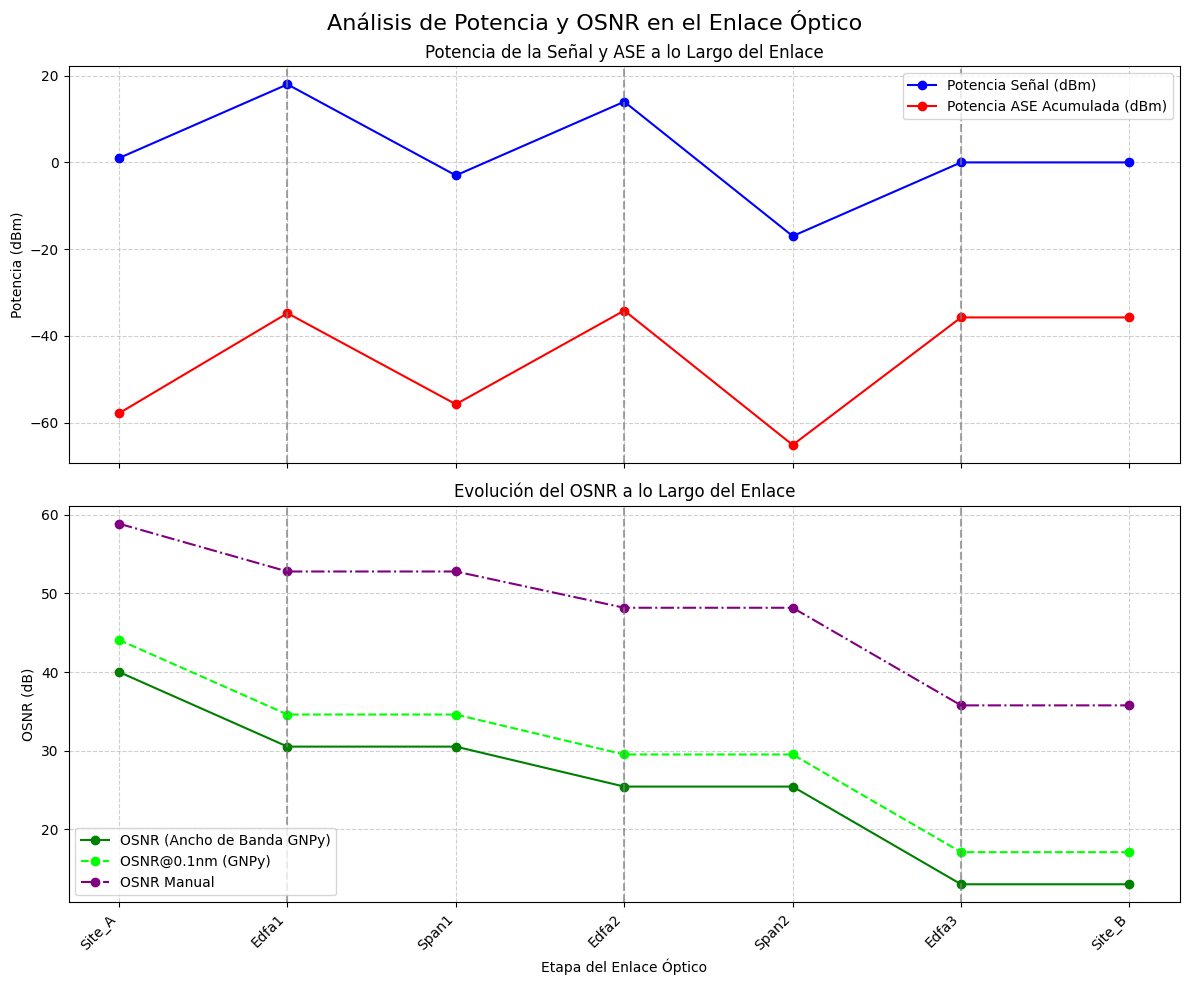

In [8]:
# Importar Edfa de gnpy.core.elements explícitamente para verificación de tipo
from gnpy.core.elements import Transceiver, Fiber, Edfa


# 1) PARÁMETROS
f_min, f_max = 191.3e12, 195.1e12
spacing = 50e9
roll_off = 0.15
tx_osnr = 40  # dB inicial
tx_power_dbm = -17.85  # dBm por canal
baud_rate = 32e9

# 2) Entradas usuario
sens = float(input("Introduce la sensibilidad del receptor en dBm: "))
nf1 = float(input("Introduce NF para EDFA1 (dB): "))
nf2 = float(input("Introduce NF para EDFA2 (dB): "))
nf3 = float(input("Introduce NF para EDFA3 (dB): "))

# 3) Helpers OSNR
def get_avg_osnr_db(si):
    sig = np.array([np.sum(ch.power) for ch in si.carriers])
    noise = si.ase
    return float(np.mean(lin2db(np.where(noise > 0, sig / noise, np.inf))))

def get_avg_osnr_01nm_db(si):
    return get_avg_osnr_db(si) + 10 * np.log10(si.baud_rate[0] / 12.5e9)

def format_osnr(v):
    return "∞" if np.isinf(v) else f"{v:.2f}"

def classical_osnr_parallel(signal_power_dbm, ase_noise_dbm):
    if ase_noise_dbm == -float('inf') or ase_noise_dbm <= -190: # Considerar ruido muy bajo
        return float('inf') # OSNR muy alto si el ruido es casi cero

    signal_power_lin = dbm2watt(signal_power_dbm)
    ase_noise_lin = dbm2watt(ase_noise_dbm)

    if ase_noise_lin <= 0:
        return float('inf') # Evitar división por cero o negativo

    return lin2db(signal_power_lin / ase_noise_lin)


# 4) SpectralInformation inicial
nch = int(np.floor((f_max - f_min) / spacing)) + 1
freq = [f_min + spacing * i for i in range(nch)]
signal = [dbm2watt(tx_power_dbm)] * nch
delta = np.zeros(nch)
label = [f"{baud_rate * 1e-9:.2f}G"] * nch

si = create_arbitrary_spectral_information(
    freq, slot_width=spacing, signal=signal,
    baud_rate=baud_rate, roll_off=roll_off,
    delta_pdb_per_channel=delta,
    tx_osnr=tx_osnr, tx_power=tx_power_dbm, label=label
)
si.signal = si.signal.astype(np.float64)
si.nli = si.nli.astype(np.float64)
# Forzar ASE inicial para OSNR Tx exacto
lin_osnr0 = 10**(tx_osnr / 10)
si.ase = np.array([np.sum(ch.power) / lin_osnr0 for ch in si.carriers], dtype=np.float64)


# Inicializar el ruido ASE acumulado
current_accumulated_ase_noise_lin = 0.0

# Listas para almacenar datos de la gráfica
etapas_labels = []
potencia_senal_dbm_values = []
potencia_ase_dbm_values = []
osnr_bw_values = []
osnr_01nm_values = []
osnr_manual_values = []
stage_indices = []
current_stage_index = 0

# 5) Cargar red y equipo
equipment = load_equipment(Path("eqpt_config.json"))
network = load_network(Path("topologiaEdfa.json"), equipment)
tx = next(n for n in network.nodes if isinstance(n, Transceiver) and n.uid == "Site_A")
rx = next(n for n in network.nodes if isinstance(n, Transceiver) and n.uid == "Site_B")
edfas = sorted([n for n in network.nodes if isinstance(n, Edfa)], key=lambda x: x.uid)
fibs = sorted([n for n in network.nodes if isinstance(n, Fiber)], key=lambda x: x.uid)
span1, span2 = fibs[0], fibs[1]

# 6) Imprimir tabla
header = f"{'Etapa':>10s} | {'Pot':>8s} | {'OSNR_bw':>8s} | {'OSNR@0.1nm':>10s} | {'OSNR_Manual':>15s}"
print("\n" + header)
print("-" * len(header))

# Función para fila genérica (modificada para guardar datos de la gráfica)
def print_stage(name, si_current, nf=None, current_ase_lin=None):
    global current_stage_index

    p_dbm = watt2dbm(sum(ch.power[0] for ch in si_current.carriers))
    osnr_db = get_avg_osnr_db(si_current)
    osnr01_db = get_avg_osnr_01nm_db(si_current)

    # Cálculo del OSNR manual
    osnr_manual_val = '     -     '
    calculated_osnr_manual = np.nan
    if current_ase_lin is not None and current_ase_lin > 0:
        calculated_osnr_manual = classical_osnr_parallel(p_dbm, watt2dbm(current_ase_lin))
        osnr_manual_val = format_osnr(calculated_osnr_manual)
    elif current_ase_lin == 0:
        calculated_osnr_manual = float('inf')
        osnr_manual_val = "∞"

    print(f"{name:>10s} | {p_dbm:8.2f} | {format_osnr(osnr_db):>8s} | {format_osnr(osnr01_db):>10s} | {osnr_manual_val:>15s}")

    # Guardar datos para la gráfica
    etapas_labels.append(name)
    potencia_senal_dbm_values.append(p_dbm)
    potencia_ase_dbm_values.append(watt2dbm(current_ase_lin) if (current_ase_lin is not None and current_ase_lin > 0) else -200.0)
    osnr_bw_values.append(osnr_db)
    osnr_01nm_values.append(osnr01_db)
    osnr_manual_values.append(calculated_osnr_manual)
    stage_indices.append(current_stage_index)
    current_stage_index += 1


# Inicialización
si_current = copy.deepcopy(si)
p0 = watt2dbm(sum(ch.power[0] for ch in si_current.carriers))
o0 = tx_osnr
o0_1 = tx_osnr + 10 * np.log10(baud_rate / 12.5e9)
initial_ase_lin = dbm2watt(tx_power_dbm) / (10**(tx_osnr / 10))
current_accumulated_ase_noise_lin = initial_ase_lin
print_stage(tx.uid, si_current, current_ase_lin=current_accumulated_ase_noise_lin)

# EDFA1
edfa1 = next(n for n in network.nodes if isinstance(n, Edfa) and n.uid == "Edfa1")
si_current = edfa1(si_current)
gain1_db = edfa1.operational.gain_target
noise_factor1_db = nf1
QUANTUM_NOISE_FLOOR_DBM = -58.0
p_ase_edfa1_lin = dbm2watt(QUANTUM_NOISE_FLOOR_DBM + noise_factor1_db + gain1_db)
current_accumulated_ase_noise_lin = (current_accumulated_ase_noise_lin * 10**(gain1_db / 10)) + p_ase_edfa1_lin
print_stage(edfa1.uid, si_current, nf1, current_accumulated_ase_noise_lin)

# Span1
ase1, nli1 = si_current.ase.copy(), si_current.nli.copy()
span1.ref_pch_in_dbm = watt2dbm(sum(ch.power[0] for ch in si_current.carriers)) - 10 * np.log10(nch)
si_current = span1(si_current)
loss1_dB = span1.params.loss_coef * span1.params.length + span1.params.con_in + span1.params.con_out + span1.params.att_in
loss1_lin = 10**(-loss1_dB / 10)
si_current.ase = ase1 * loss1_lin
si_current.nli = nli1 * loss1_lin
current_accumulated_ase_noise_lin = current_accumulated_ase_noise_lin * loss1_lin
print_stage(span1.uid, si_current, current_ase_lin=current_accumulated_ase_noise_lin)

# EDFA2
edfa2 = next(n for n in network.nodes if isinstance(n, Edfa) and n.uid == "Edfa2")
edfa2.ref_pch_in_dbm = watt2dbm(sum(ch.power[0] for ch in si_current.carriers)) - 10 * np.log10(nch)
si_current = edfa2(si_current)
gain2_db = edfa2.operational.gain_target
noise_factor2_db = nf2
p_ase_edfa2_lin = dbm2watt(QUANTUM_NOISE_FLOOR_DBM + noise_factor2_db + gain2_db)
current_accumulated_ase_noise_lin = (current_accumulated_ase_noise_lin * 10**(gain2_db / 10)) + p_ase_edfa2_lin
print_stage(edfa2.uid, si_current, nf2, current_accumulated_ase_noise_lin)

# Span2
ase2, nli2 = si_current.ase.copy(), si_current.nli.copy()
span2.ref_pch_in_dbm = watt2dbm(sum(ch.power[0] for ch in si_current.carriers)) - 10 * np.log10(nch)
si_current = span2(si_current)
loss2_dB = span2.params.loss_coef * span2.params.length + span2.params.con_in + span2.params.con_out + span2.params.att_in
loss2_lin = 10**(-loss2_dB / 10)
si_current.ase = ase2 * loss2_lin
si_current.nli = nli2 * loss2_lin
current_accumulated_ase_noise_lin = current_accumulated_ase_noise_lin * loss2_lin
print_stage(span2.uid, si_current, current_ase_lin=current_accumulated_ase_noise_lin)

# EDFA3
edfa3 = next(n for n in network.nodes if isinstance(n, Edfa) and n.uid == "Edfa3")
edfa3.ref_pch_in_dbm = watt2dbm(sum(ch.power[0] for ch in si_current.carriers)) - 10 * np.log10(nch)
si_current = edfa3(si_current)
gain3_db = edfa3.operational.gain_target
noise_factor3_db = nf3
p_ase_edfa3_lin = dbm2watt(QUANTUM_NOISE_FLOOR_DBM + noise_factor3_db + gain3_db)
current_accumulated_ase_noise_lin = (current_accumulated_ase_noise_lin * 10**(gain3_db / 10)) + p_ase_edfa3_lin
print_stage(edfa3.uid, si_current, nf3, current_accumulated_ase_noise_lin)

# Receptor final
si_current = rx(si_current)
print_stage(rx.uid, si_current, current_ase_lin=current_accumulated_ase_noise_lin)

# Verificar la sensibilidad y mostrar la advertencia/éxito
p_rb = watt2dbm(sum(ch.power[0] for ch in si_current.carriers))
if p_rb < sens:
    print(f"\nAdvertencia: La potencia de la señal recibida ({p_rb:.2f} dBm) "
          f"es menor que la sensibilidad del receptor ({sens:.2f} dBm).")
else:
    print(f"\n¡Éxito! La potencia de la señal recibida ({p_rb:.2f} dBm) "
          f"es mayor o igual que la sensibilidad del receptor ({sens:.2f} dBm).")
# ---------------------------------------------------------------

## Gráficas de Potencia y OSNR vs. Etapa

def plot_osnr_vs_spans():
    fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    fig.subplots_adjust(top=0.92)

    # Subplot 1: Potencia de la Señal y ASE
    ax_power = axs[0]
    ax_power.plot(stage_indices, potencia_senal_dbm_values, marker='o', linestyle='-', color='blue', label='Potencia Señal (dBm)')
    plot_ase_values = [val if np.isfinite(val) else -200 for val in potencia_ase_dbm_values]
    ax_power.plot(stage_indices, plot_ase_values, marker='o', linestyle='-', color='red', label='Potencia ASE Acumulada (dBm)')
    ax_power.set_ylabel('Potencia (dBm)')
    ax_power.legend(loc='upper right')
    ax_power.grid(True, linestyle='--', alpha=0.6)
    ax_power.set_title('Potencia de la Señal y ASE a lo Largo del Enlace', fontsize=12)

    # Subplot 2: OSNRs
    ax_osnr = axs[1]
    ax_osnr.plot(stage_indices, osnr_bw_values, marker='o', linestyle='-', color='green', label='OSNR (Ancho de Banda GNPy)')
    ax_osnr.plot(stage_indices, osnr_01nm_values, marker='o', linestyle='--', color='lime', label='OSNR@0.1nm (GNPy)')
    plot_osnr_manual_values = [val if np.isfinite(val) else np.nan for val in osnr_manual_values]
    ax_osnr.plot(stage_indices, plot_osnr_manual_values, marker='o', linestyle='-.', color='purple', label='OSNR Manual')
    ax_osnr.set_ylabel('OSNR (dB)')
    ax_osnr.set_xlabel('Etapa del Enlace Óptico')
    ax_osnr.grid(True, linestyle='--', alpha=0.6)
    ax_osnr.legend(loc='lower left')
    ax_osnr.set_xticks(stage_indices)
    ax_osnr.set_xticklabels(etapas_labels, rotation=45, ha='right')
    ax_osnr.set_title('Evolución del OSNR a lo Largo del Enlace', fontsize=12)

    # Añadir líneas verticales para los elementos activos (EDFAs)
    edfa_stages_indices = [i for i, label in enumerate(etapas_labels) if "Edfa" in label]
    for edfa_idx in edfa_stages_indices:
        ax_power.axvline(edfa_idx, color='gray', linestyle='--', alpha=0.7, label='EDFA' if edfa_idx == edfa_stages_indices[0] else "")
        ax_osnr.axvline(edfa_idx, color='gray', linestyle='--', alpha=0.7, label='EDFA' if edfa_idx == edfa_stages_indices[0] else "")
    
    # Añadir un título general para toda la figura
    fig.suptitle('Análisis de Potencia y OSNR en el Enlace Óptico', fontsize=16)

    plt.tight_layout()
    plt.show()

# Llamar a la función de graficado al final de la ejecución
plot_osnr_vs_spans()